# 03b - Transfer Learning Models

**Goal**: Train ResNet50 and EfficientNet-B0 using transfer learning

**What we'll do**:
1. Load pretrained models
2. Modify final layers for emotion classification
3. Train with frozen backbone, then fine-tune
4. Save best models for comparison

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import yaml
from pathlib import Path
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

print("✅ Imports successful")

✅ Imports successful


In [2]:
# Load config
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Paths
PROJECT_ROOT = Path(os.path.dirname(Path.cwd()))
PROCESSED_DIR = PROJECT_ROOT / config['data']['processed_dir']
MODELS_DIR = PROJECT_ROOT / config['paths']['final_models_dir']
MODELS_DIR.mkdir(exist_ok=True, parents=True)

# Training params
NUM_CLASSES = config['data']['num_classes']
BATCH_SIZE = config['training']['batch_size']
LEARNING_RATE = config['training']['learning_rate']
EPOCHS = 30  # Fewer epochs for transfer learning

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"\n📁 Saving models to: {MODELS_DIR}")

Using device: cuda

📁 Saving models to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final


## Load Data

In [3]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard for pretrained models
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=config['data']['normalize_mean'],
        std=config['data']['normalize_std']
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=config['data']['normalize_mean'],
        std=config['data']['normalize_std']
    )
])

# Datasets
train_dataset = datasets.ImageFolder(str(PROCESSED_DIR / 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(str(PROCESSED_DIR / 'val'), transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"✅ Data loaded")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Classes: {train_dataset.classes}")

✅ Data loaded
  Training samples: 39823
  Validation samples: 4978
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Training Functions

In [4]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / len(loader), correct / total

print("✅ Training functions defined")

✅ Training functions defined


## Train ResNet50

In [5]:
print("\n" + "="*70)
print("🔥 Training ResNet50")
print("="*70)

# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace final layer
resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES)
resnet = resnet.to(device)

print(f"✅ Model loaded (pretrained=True)")
print(f"   Backbone: Frozen")
print(f"   Final layer: {resnet.fc.in_features} -> {NUM_CLASSES}")


🔥 Training ResNet50


/home/steph-grigors/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/steph-grigors/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/steph-grigors/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:10<00:00, 9.40MB/s]


✅ Model loaded (pretrained=True)
   Backbone: Frozen
   Final layer: 2048 -> 7


In [6]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=LEARNING_RATE)  # Only train final layer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    patience=3,
    factor=0.5
)

# Track best model
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n🎯 Training with frozen backbone...")


🎯 Training with frozen backbone...


In [7]:
# Train
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(resnet, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(resnet, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), MODELS_DIR / 'resnet50_best.pth')
        print(f"💾 Saved new best model (Val Acc: {val_acc*100:.2f}%)")

print(f"\n✅ ResNet50 training complete!")
print(f"   Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"   Model saved: {MODELS_DIR / 'resnet50_best.pth'}")


Epoch 1/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.60it/s]


Train Loss: 1.5433 | Train Acc: 40.24%
Val Loss: 1.4564 | Val Acc: 43.67%
💾 Saved new best model (Val Acc: 43.67%)

Epoch 2/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]


Train Loss: 1.4827 | Train Acc: 42.86%
Val Loss: 1.4462 | Val Acc: 44.90%
💾 Saved new best model (Val Acc: 44.90%)

Epoch 3/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.77it/s]


Train Loss: 1.4527 | Train Acc: 44.50%
Val Loss: 1.4119 | Val Acc: 45.44%
💾 Saved new best model (Val Acc: 45.44%)

Epoch 4/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.62it/s]


Train Loss: 1.4374 | Train Acc: 44.82%
Val Loss: 1.4321 | Val Acc: 44.03%

Epoch 5/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.18it/s]


Train Loss: 1.4296 | Train Acc: 45.67%
Val Loss: 1.3768 | Val Acc: 47.81%
💾 Saved new best model (Val Acc: 47.81%)

Epoch 6/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.94it/s]


Train Loss: 1.4188 | Train Acc: 45.77%
Val Loss: 1.4275 | Val Acc: 44.86%

Epoch 7/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.42it/s]


Train Loss: 1.4183 | Train Acc: 45.89%
Val Loss: 1.5798 | Val Acc: 39.88%

Epoch 8/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.56it/s]


Train Loss: 1.4061 | Train Acc: 46.34%
Val Loss: 1.3885 | Val Acc: 46.22%

Epoch 9/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.62it/s]


Train Loss: 1.3972 | Train Acc: 46.75%
Val Loss: 1.3896 | Val Acc: 46.56%

Epoch 10/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.01it/s]


Train Loss: 1.3490 | Train Acc: 48.46%
Val Loss: 1.3424 | Val Acc: 48.90%
💾 Saved new best model (Val Acc: 48.90%)

Epoch 11/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.53it/s]


Train Loss: 1.3488 | Train Acc: 48.65%
Val Loss: 1.3633 | Val Acc: 48.29%

Epoch 12/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.59it/s]


Train Loss: 1.3432 | Train Acc: 48.55%
Val Loss: 1.3585 | Val Acc: 48.17%

Epoch 13/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.55it/s]


Train Loss: 1.3503 | Train Acc: 48.59%
Val Loss: 1.3963 | Val Acc: 46.75%

Epoch 14/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.71it/s]


Train Loss: 1.3447 | Train Acc: 48.57%
Val Loss: 1.3593 | Val Acc: 47.47%

Epoch 15/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.21it/s]


Train Loss: 1.3190 | Train Acc: 49.59%
Val Loss: 1.3117 | Val Acc: 50.06%
💾 Saved new best model (Val Acc: 50.06%)

Epoch 16/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.66it/s]


Train Loss: 1.3134 | Train Acc: 49.78%
Val Loss: 1.3182 | Val Acc: 50.64%
💾 Saved new best model (Val Acc: 50.64%)

Epoch 17/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.45it/s]


Train Loss: 1.3136 | Train Acc: 49.85%
Val Loss: 1.3409 | Val Acc: 48.88%

Epoch 18/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.65it/s]


Train Loss: 1.3113 | Train Acc: 49.89%
Val Loss: 1.3300 | Val Acc: 49.16%

Epoch 19/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.15it/s]


Train Loss: 1.3133 | Train Acc: 49.90%
Val Loss: 1.3177 | Val Acc: 50.50%

Epoch 20/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.87it/s]


Train Loss: 1.2995 | Train Acc: 50.44%
Val Loss: 1.3169 | Val Acc: 50.16%

Epoch 21/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.79it/s]


Train Loss: 1.2980 | Train Acc: 50.66%
Val Loss: 1.3044 | Val Acc: 50.38%

Epoch 22/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.35it/s]


Train Loss: 1.3002 | Train Acc: 50.27%
Val Loss: 1.3079 | Val Acc: 50.72%
💾 Saved new best model (Val Acc: 50.72%)

Epoch 23/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.86it/s]


Train Loss: 1.2997 | Train Acc: 50.24%
Val Loss: 1.3012 | Val Acc: 50.30%

Epoch 24/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.27it/s]


Train Loss: 1.2941 | Train Acc: 50.79%
Val Loss: 1.3110 | Val Acc: 50.06%

Epoch 25/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.08it/s]


Train Loss: 1.2941 | Train Acc: 50.35%
Val Loss: 1.3054 | Val Acc: 50.18%

Epoch 26/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.37it/s]


Train Loss: 1.2963 | Train Acc: 50.83%
Val Loss: 1.3233 | Val Acc: 49.44%

Epoch 27/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.11it/s]


Train Loss: 1.2945 | Train Acc: 50.57%
Val Loss: 1.3120 | Val Acc: 50.74%
💾 Saved new best model (Val Acc: 50.74%)

Epoch 28/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.17it/s]


Train Loss: 1.2910 | Train Acc: 50.65%
Val Loss: 1.3015 | Val Acc: 50.48%

Epoch 29/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.90it/s]


Train Loss: 1.2952 | Train Acc: 50.64%
Val Loss: 1.3070 | Val Acc: 50.16%

Epoch 30/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.39it/s]

Train Loss: 1.2904 | Train Acc: 50.59%
Val Loss: 1.3082 | Val Acc: 49.74%

✅ ResNet50 training complete!
   Best validation accuracy: 50.74%
   Model saved: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/resnet50_best.pth


## Train EfficientNet-B0

In [22]:
print("\n" + "="*70)
print("🔥 Training EfficientNet-B0")
print("="*70)

# Load EfficientNet-B0 from timm (avoids PyTorch hash issues)
efficientnet = timm.create_model("efficientnet_b0", pretrained=True)

# Freeze all layers
for param in efficientnet.parameters():
    param.requires_grad = False

# Replace classifier (timm uses different naming than torchvision)
in_features = efficientnet.classifier.in_features
efficientnet.classifier = nn.Linear(in_features, NUM_CLASSES)
efficientnet = efficientnet.to(device)

print(f"✅ Model loaded (pretrained=True, from timm)")
print(f"   Source: timm library (PyTorch Image Models)")
print(f"   Backbone: Frozen")
print(f"   Final layer: {in_features} -> {NUM_CLASSES}")


🔥 Training EfficientNet-B0
✅ Model loaded (pretrained=True, from timm)
   Source: timm library (PyTorch Image Models)
   Backbone: Frozen
   Final layer: 1280 -> 7


In [24]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.classifier.parameters(), lr=LEARNING_RATE)  # Works the same
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    patience=3,
    factor=0.5
)

# Track best model
best_val_acc = 0.0
history_eff = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n🎯 Training with frozen backbone...")


🎯 Training with frozen backbone...


In [25]:
# Train
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(efficientnet, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(efficientnet, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    # Save history
    history_eff['train_loss'].append(train_loss)
    history_eff['train_acc'].append(train_acc)
    history_eff['val_loss'].append(val_loss)
    history_eff['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(efficientnet.state_dict(), MODELS_DIR / 'efficientnet_best.pth')
        print(f"💾 Saved new best model (Val Acc: {val_acc*100:.2f}%)")

print(f"\n✅ EfficientNet training complete!")
print(f"   Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"   Model saved: {MODELS_DIR / 'efficientnet_best.pth'}")


Epoch 1/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.94it/s]


Train Loss: 1.4693 | Train Acc: 42.86%
Val Loss: 1.4208 | Val Acc: 45.48%
💾 Saved new best model (Val Acc: 45.48%)

Epoch 2/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.16it/s]


Train Loss: 1.3937 | Train Acc: 46.40%
Val Loss: 1.4197 | Val Acc: 44.86%

Epoch 3/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.22it/s]


Train Loss: 1.3734 | Train Acc: 47.41%
Val Loss: 1.3948 | Val Acc: 46.75%
💾 Saved new best model (Val Acc: 46.75%)

Epoch 4/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 21.63it/s]


Train Loss: 1.3609 | Train Acc: 47.61%
Val Loss: 1.3965 | Val Acc: 46.89%
💾 Saved new best model (Val Acc: 46.89%)

Epoch 5/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.28it/s]


Train Loss: 1.3636 | Train Acc: 47.86%
Val Loss: 1.3835 | Val Acc: 47.15%
💾 Saved new best model (Val Acc: 47.15%)

Epoch 6/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.42it/s]


Train Loss: 1.3517 | Train Acc: 48.22%
Val Loss: 1.3892 | Val Acc: 47.21%
💾 Saved new best model (Val Acc: 47.21%)

Epoch 7/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.05it/s]


Train Loss: 1.3511 | Train Acc: 48.78%
Val Loss: 1.3942 | Val Acc: 46.38%

Epoch 8/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.06it/s]


Train Loss: 1.3495 | Train Acc: 48.18%
Val Loss: 1.4043 | Val Acc: 47.13%

Epoch 9/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.91it/s]


Train Loss: 1.3492 | Train Acc: 48.51%
Val Loss: 1.3938 | Val Acc: 46.42%

Epoch 10/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.15it/s]


Train Loss: 1.3348 | Train Acc: 49.00%
Val Loss: 1.3758 | Val Acc: 47.99%
💾 Saved new best model (Val Acc: 47.99%)

Epoch 11/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.68it/s]


Train Loss: 1.3313 | Train Acc: 49.15%
Val Loss: 1.3747 | Val Acc: 47.63%

Epoch 12/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.21it/s]


Train Loss: 1.3251 | Train Acc: 49.64%
Val Loss: 1.3781 | Val Acc: 47.29%

Epoch 13/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.41it/s]


Train Loss: 1.3283 | Train Acc: 49.39%
Val Loss: 1.3777 | Val Acc: 47.53%

Epoch 14/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.81it/s]


Train Loss: 1.3321 | Train Acc: 49.05%
Val Loss: 1.3756 | Val Acc: 48.23%
💾 Saved new best model (Val Acc: 48.23%)

Epoch 15/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.78it/s]


Train Loss: 1.3228 | Train Acc: 49.52%
Val Loss: 1.3740 | Val Acc: 47.43%

Epoch 16/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.21it/s]


Train Loss: 1.3275 | Train Acc: 49.25%
Val Loss: 1.3819 | Val Acc: 47.17%

Epoch 17/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.40it/s]


Train Loss: 1.3255 | Train Acc: 49.23%
Val Loss: 1.3734 | Val Acc: 47.75%

Epoch 18/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.29it/s]


Train Loss: 1.3256 | Train Acc: 49.29%
Val Loss: 1.3782 | Val Acc: 47.17%

Epoch 19/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 21.73it/s]


Train Loss: 1.3256 | Train Acc: 49.63%
Val Loss: 1.3834 | Val Acc: 47.09%

Epoch 20/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 23.00it/s]


Train Loss: 1.3256 | Train Acc: 49.26%
Val Loss: 1.3688 | Val Acc: 47.37%

Epoch 21/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.66it/s]


Train Loss: 1.3234 | Train Acc: 49.56%
Val Loss: 1.3809 | Val Acc: 46.95%

Epoch 22/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.43it/s]


Train Loss: 1.3276 | Train Acc: 49.86%
Val Loss: 1.3843 | Val Acc: 47.27%

Epoch 23/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.80it/s]


Train Loss: 1.3278 | Train Acc: 49.42%
Val Loss: 1.3813 | Val Acc: 46.75%

Epoch 24/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.91it/s]


Train Loss: 1.3271 | Train Acc: 49.60%
Val Loss: 1.3613 | Val Acc: 47.91%

Epoch 25/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.15it/s]


Train Loss: 1.3277 | Train Acc: 49.42%
Val Loss: 1.3632 | Val Acc: 47.79%

Epoch 26/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.56it/s]


Train Loss: 1.3251 | Train Acc: 49.22%
Val Loss: 1.3652 | Val Acc: 47.55%

Epoch 27/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.84it/s]


Train Loss: 1.3230 | Train Acc: 49.92%
Val Loss: 1.3868 | Val Acc: 47.11%

Epoch 28/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.54it/s]


Train Loss: 1.3255 | Train Acc: 49.31%
Val Loss: 1.3784 | Val Acc: 47.83%

Epoch 29/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.11it/s]


Train Loss: 1.3179 | Train Acc: 49.67%
Val Loss: 1.3733 | Val Acc: 47.51%

Epoch 30/30


Validation: 100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.23it/s]

Train Loss: 1.3130 | Train Acc: 49.93%
Val Loss: 1.3884 | Val Acc: 47.01%

✅ EfficientNet training complete!
   Best validation accuracy: 48.23%
   Model saved: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/efficientnet_best.pth


## Training Curves Comparison

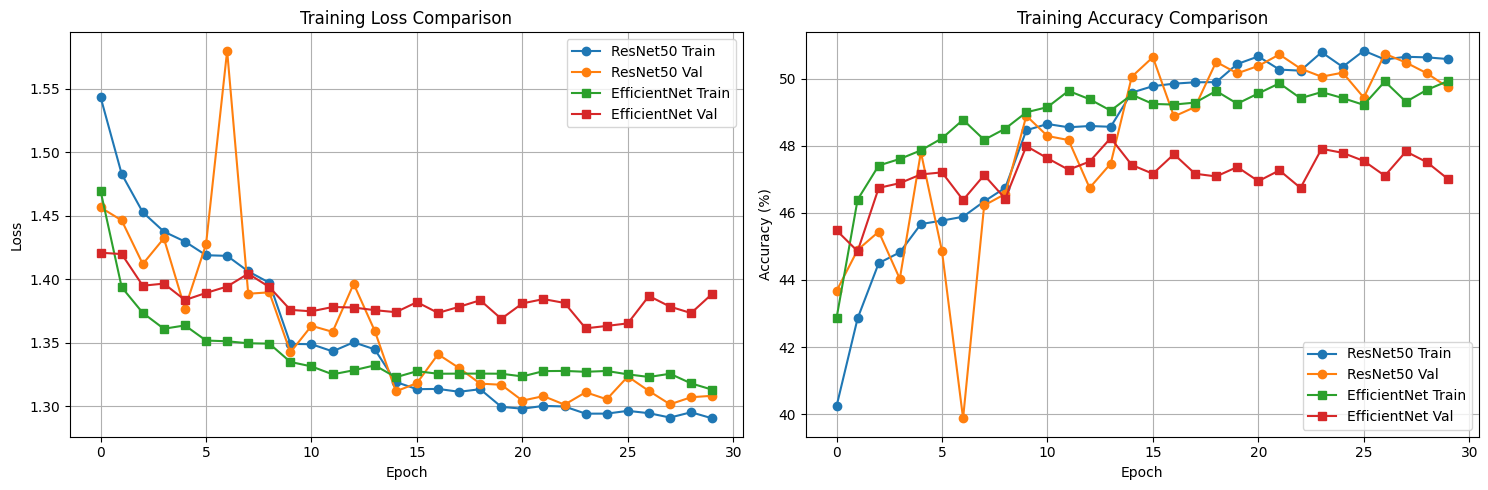

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='ResNet50 Train', marker='o')
axes[0].plot(history['val_loss'], label='ResNet50 Val', marker='o')
axes[0].plot(history_eff['train_loss'], label='EfficientNet Train', marker='s')
axes[0].plot(history_eff['val_loss'], label='EfficientNet Val', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot([x*100 for x in history['train_acc']], label='ResNet50 Train', marker='o')
axes[1].plot([x*100 for x in history['val_acc']], label='ResNet50 Val', marker='o')
axes[1].plot([x*100 for x in history_eff['train_acc']], label='EfficientNet Train', marker='s')
axes[1].plot([x*100 for x in history_eff['val_acc']], label='EfficientNet Val', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Summary

In [27]:
print("\n" + "="*70)
print("✅ TRANSFER LEARNING COMPLETE")
print("="*70)

print(f"\n📊 Models trained:")
print(f"  1. ResNet50")
print(f"  2. EfficientNet-B0")

print(f"\n💾 Saved models:")
print(f"  {MODELS_DIR / 'resnet50_best.pth'}")
print(f"  {MODELS_DIR / 'efficientnet_best.pth'}")

print(f"\n📈 Next step: Run notebook 04 to compare all models!")
print("="*70)


✅ TRANSFER LEARNING COMPLETE

📊 Models trained:
  1. ResNet50
  2. EfficientNet-B0

💾 Saved models:
  /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/resnet50_best.pth
  /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/efficientnet_best.pth

📈 Next step: Run notebook 04 to compare all models!
